## Imports

In [7]:
import os
import json
import random
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchaudio.transforms as T
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
import random

import librosa
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Utils

In [9]:
def get_model_size(model):
    param_size = 0
    buffer_size = 0
    total_params = 0
    trainable_params = 0

    for param in model.parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
        param_size += param.numel() * param.element_size()  # size in bytes

    for buffer in model.buffers():
        buffer_size += buffer.numel() * buffer.element_size()

    total_size_mb = (param_size + buffer_size) / (1024 ** 2)  # Convert bytes to MB

    print(f"Model size       : {total_size_mb:.4f} MB")
    print(f"Total parameters : {total_params:,}")
    print(f"Trainable params : {trainable_params:,}")

    return {
        "size_mb": total_size_mb,
        "total_params": total_params,
        "trainable_params": trainable_params
    }



In [10]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)

def plot_mono_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = 1, waveform.shape[0]
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform, linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")

In [11]:
from datetime import datetime
import time

class DiPCoSeparationDataset(Dataset):
    def __init__(self, root_dir='./data/Dipco/', session_ids=['S02', 'S04'], version='dev', 
                segment_length=4, sr=16000, max_pairs=10000, seed=0):
        
        self.sr = sr
        self.segment_samples = int(sr * segment_length)
        
        self.session_dict:dict[list] = {}
        self.pairs = []
        self.session_audio:dict[tuple[str, str],torch.Tensor] = {}
        

        for session_id in session_ids:
            trans_path = os.path.join(root_dir, 'transcriptions', version, f'{session_id}.json')
            print('Processing: ', trans_path)
            with open(trans_path, 'r') as f:
                session_trans = json.load(f)

            for utt in tqdm(session_trans):
                curr_speaker_id = utt['speaker_id']
                curr_valid_times = self.session_dict.get((session_id, curr_speaker_id), [])
                curr_start_time = self._time_str_to_sample(utt['start_time'], sr)
                curr_end_time = self._time_str_to_sample(utt['end_time'], sr)
                
                curr_valid_times.extend([(start, start + segment_length * sr) for start in range(curr_start_time, curr_end_time, self.segment_samples)])
                self.session_dict[(session_id, curr_speaker_id)] = curr_valid_times


            for speaker_1 in list(self.session_dict.keys())[:-1]:
                if speaker_1[0] != session_id:
                    continue
                speaker_1_times = self.session_dict[speaker_1]
                for speaker_2 in list(self.session_dict)[1:]:
                    if speaker_2[0] != session_id:
                        continue
                    speaker_2_times = self.session_dict[speaker_2]
                    for time1 in speaker_1_times:
                        for time2 in speaker_2_times:
                            self.pairs.append((speaker_1, time1, speaker_2, time2))
                            
            random.seed(seed)  
            random.shuffle(self.pairs)
            self.pairs = self.pairs[:max_pairs]

        for (key_session_id, key_speaker_id), times in self.session_dict.items():
            print((key_session_id, key_speaker_id), len(times), times)
            audio_path = os.path.join(root_dir, 'audio', version,
                                    f"{key_session_id}_{key_speaker_id}.wav")
            self.session_audio[(key_session_id, key_speaker_id)] = self._load_full_audio(audio_path)

            print((key_session_id, key_speaker_id),'audio length:',len(self.session_audio[(key_session_id, key_speaker_id)]))


    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        (speaker_1, time1, speaker_2, time2) = self.pairs[idx]
        audio1 = self.session_audio[speaker_1]
        audio2 = self.session_audio[speaker_2]
        if time1[1] > audio1.size(0):
            time1 = (audio1.size(0) - self.segment_samples, audio1.size(0))
        if time2[1] > audio2.size(0):
            time2 = (audio2.size(0) - self.segment_samples, audio2.size(0))
        clean1 = audio1[time1[0]:time1[1]]
        clean2 = audio2[time2[0]:time2[1]]

        mixed = (clean1 + clean2).clamp(-1, 1)

        clean1 = clean1
        clean2 = clean2
        mixed = mixed.unsqueeze(0)

        return mixed, torch.stack([clean1, clean2])

    def _time_str_to_sample(self, t_dict, sr):
        t_str = t_dict[list(t_dict.keys())[0]]
        t = datetime.strptime(t_str, "%H:%M:%S.%f")
        return int(sr * (t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1_000_000))
    
    def _load_full_audio(self, path):
        waveform, orig_sr = torchaudio.load(path)
        if orig_sr != self.sr:
            resampler = torchaudio.transforms.Resample(orig_sr, self.sr)
            waveform = resampler(waveform)
        waveform = torch.mean(waveform, dim=0)  # Convert to mono
        return waveform

In [12]:
train_dataset = DiPCoSeparationDataset(
    root_dir='../data/Dipco/',
    session_ids=['S02', 'S04'],#, 'S04', 'S05', 'S09', 'S10'],
    segment_length=4,
    sr=8000,
    max_pairs=1_000_000,
)
len(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=16//8, shuffle=False)
len(train_dataset.pairs), train_dataset.pairs[0], len(train_loader)

Processing:  ../data/Dipco/transcriptions\dev\S02.json


  0%|          | 0/448 [00:00<?, ?it/s]

Processing:  ../data/Dipco/transcriptions\dev\S04.json


  0%|          | 0/1284 [00:00<?, ?it/s]

('S02', 'P05') 200 [(19680, 51680), (66800, 98800), (639360, 671360), (732800, 764800), (762320, 794320), (784240, 816240), (864560, 896560), (880720, 912720), (912720, 944720), (1062320, 1094320), (1105280, 1137280), (1147840, 1179840), (1247280, 1279280), (1272080, 1304080), (1349200, 1381200), (1443200, 1475200), (1471680, 1503680), (1503600, 1535600), (1541520, 1573520), (1593680, 1625680), (1896960, 1928960), (2023120, 2055120), (2106400, 2138400), (2138400, 2170400), (2165440, 2197440), (2172000, 2204000), (2212320, 2244320), (2285760, 2317760), (2317760, 2349760), (2329120, 2361120), (2356160, 2388160), (2391600, 2423600), (2417760, 2449760), (2575760, 2607760), (2607760, 2639760), (2619840, 2651840), (2648320, 2680320), (2680320, 2712320), (2712320, 2744320), (2741520, 2773520), (2773520, 2805520), (2805520, 2837520), (2837520, 2869520), (2865840, 2897840), (2882240, 2914240), (2912640, 2944640), (2945680, 2977680), (2957840, 2989840), (2989840, 3021840), (3021840, 3053840), (3

(1000000,
 (('S04', 'P15'), (10095920, 10127920), ('S04', 'P14'), (21664960, 21696960)),
 500000)

In [13]:
test_dataset = DiPCoSeparationDataset(
    root_dir='../data/Dipco/',
    version='eval',
    session_ids=['S01', 'S03'],
    segment_length=4,
    sr=8000,
    max_pairs=len(train_dataset.pairs) // 10,
)
len(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=16//8, shuffle=False)
len(test_dataset.pairs), test_dataset.pairs[0], len(test_loader)

Processing:  ../data/Dipco/transcriptions\eval\S01.json


  0%|          | 0/903 [00:00<?, ?it/s]

Processing:  ../data/Dipco/transcriptions\eval\S03.json


  0%|          | 0/1127 [00:00<?, ?it/s]

('S01', 'P01') 357 [(11600, 43600), (70240, 102240), (90720, 122720), (124960, 156960), (147280, 179280), (445440, 477440), (625200, 657200), (658240, 690240), (671600, 703600), (703600, 735600), (727120, 759120), (737440, 769440), (763200, 795200), (803280, 835280), (870560, 902560), (907280, 939280), (971280, 1003280), (1003280, 1035280), (1063680, 1095680), (1232880, 1264880), (1253760, 1285760), (1377280, 1409280), (1389360, 1421360), (1409760, 1441760), (1441760, 1473760), (1450960, 1482960), (1471760, 1503760), (1484960, 1516960), (1516960, 1548960), (1531120, 1563120), (1544480, 1576480), (1574160, 1606160), (1594240, 1626240), (1626240, 1658240), (1632880, 1664880), (1647040, 1679040), (1679040, 1711040), (1697920, 1729920), (1729920, 1761920), (1735600, 1767600), (1771120, 1803120), (1827360, 1859360), (1859360, 1891360), (1881280, 1913280), (1913280, 1945280), (1945280, 1977280), (2028560, 2060560), (2041600, 2073600), (2073600, 2105600), (2081679, 2113679), (2118320, 2150320

(100000,
 (('S03', 'P10'), (20582640, 20614640), ('S03', 'P11'), (20458160, 20490160)),
 50000)

1001 torch.Size([2, 1, 32000]) torch.Size([2, 2, 32000])
1001 torch.Size([2, 1, 32000]) torch.Size([2, 2, 32000])
torch.Size([2, 1, 32000]) torch.Size([2, 2, 32000])


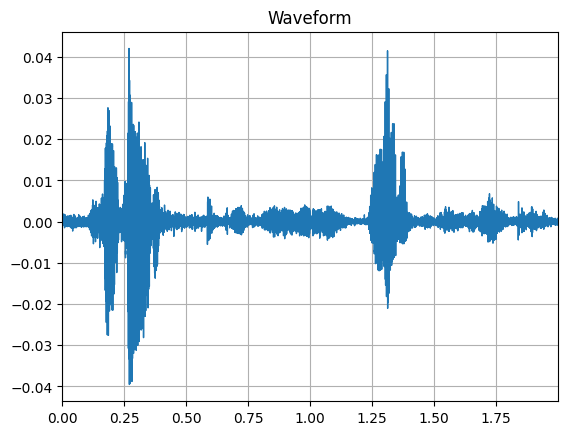

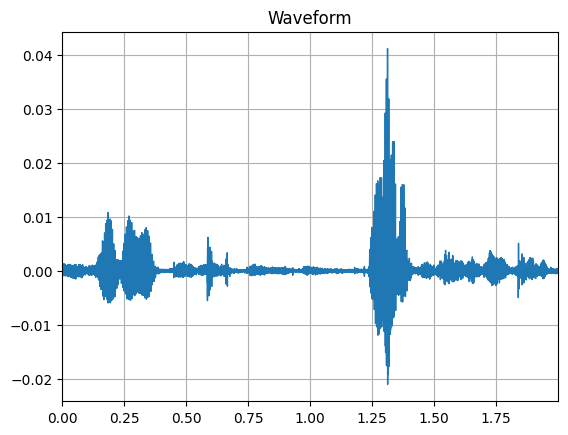

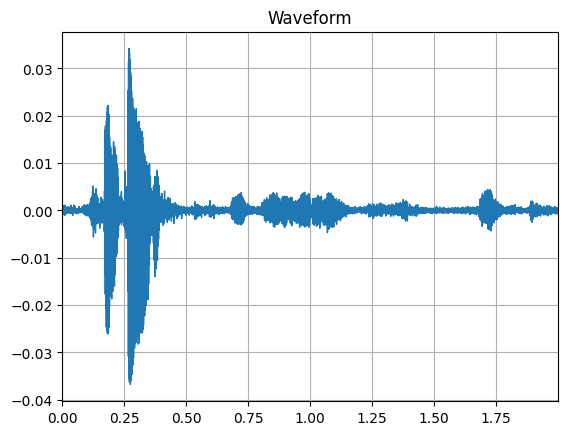

In [14]:
for idx, (mixed, clean) in enumerate(train_loader):
    print(idx, mixed.shape, clean.shape, end='\r')
    if idx > 1000:
        print()
        break
for idx, (mixed, clean) in enumerate(test_loader):
    print(idx, mixed.shape, clean.shape, end='\r')
    if idx > 1000:
        print()
        break

for mixed, clean in train_loader:
    print(mixed.shape, clean.shape)
    plot_mono_waveform(mixed[0][0], sr=16000)
    plot_mono_waveform(clean[0][0], sr=16000)
    plot_mono_waveform(clean[0][1], sr=16000)
    break



## Training

In [15]:
# class PermutationInvariantSISNRLoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.eps = 1e-8

#     def _si_snr(self, estimates, targets):
#         # estimates: [B, T]
#         # targets: [B, T]
#         estimates = estimates - estimates.mean(dim=-1, keepdim=True)
#         targets = targets - targets.mean(dim=-1, keepdim=True)

#         # Compute SI-SNR
#         s_target = (torch.sum(estimates * targets, dim=-1, keepdim=True) * targets) \
#                    / (torch.norm(targets, p=2, dim=-1, keepdim=True)**2 + self.eps)
        
#         e_noise = estimates - s_target
#         return 10 * torch.log10(
#             (torch.norm(s_target, p=2, dim=-1)**2 + self.eps) / 
#             (torch.norm(e_noise, p=2, dim=-1)**2 + self.eps)
#         )

#     def forward(self, outputs, targets):
#         """
#         Args:
#             outputs: [B, 2, T] separated waveforms
#             targets: [B, 2, T] original clean waveforms
#         Returns:
#             loss: scalar
#         """
#         # Compute all permutations
#         loss_0 = self._si_snr(outputs[:,0], targets[:,0]) + \
#                  self._si_snr(outputs[:,1], targets[:,1])
        
#         loss_1 = self._si_snr(outputs[:,0], targets[:,1]) + \
#                  self._si_snr(outputs[:,1], targets[:,0])

#         # Return negative of best permutation
#         return -torch.mean(torch.min(loss_0, loss_1))


In [16]:
# import torch
# import torch.nn as nn
# import itertools

# class SI_SNRLoss_2(nn.Module):
#     """
#     Scale-Invariant Signal-to-Noise Ratio Loss (SI-SNR) with 
#     Permutation Invariant Training (PIT) for multiple sources
#     """
#     def __init__(self, eps=1e-8):
#         super(SI_SNRLoss_2, self).__init__()
#         self.eps = eps
        
#     def forward(self, estimated, target):
#         """
#         Args:
#             estimated: Estimated sources with shape [batch_size, num_sources, time_steps]
#             target: Target sources with shape [batch_size, num_sources, time_steps]
            
#         Returns:
#             loss: Negative SI-SNR loss with the best permutation
#         """
#         batch_size, num_sources, _ = estimated.shape
        
#         # If only one source, no need for PIT
#         if num_sources == 1:
#             return self._calculate_si_snr(estimated.squeeze(1), target.squeeze(1))
        
#         # For multiple sources, use PIT
#         return self._calculate_pit_loss(estimated, target)
    
#     def _calculate_si_snr(self, estimated, target):
#         """Calculate SI-SNR between estimated and target sources"""
#         # Zero-mean normalization
#         estimated = estimated - torch.mean(estimated, dim=1, keepdim=True)
#         target = target - torch.mean(target, dim=1, keepdim=True)
        
#         # s_target calculation
#         dot_product = torch.sum(estimated * target, dim=1, keepdim=True)
#         target_energy = torch.sum(target ** 2, dim=1, keepdim=True) + self.eps
#         scaling = dot_product / target_energy
#         s_target = scaling * target
        
#         # Error calculation
#         e_noise = estimated - s_target
        
#         # SI-SNR calculation
#         s_target_energy = torch.sum(s_target ** 2, dim=1)
#         e_noise_energy = torch.sum(e_noise ** 2, dim=1) + self.eps
#         si_snr = 10 * torch.log10(s_target_energy / e_noise_energy)
        
#         return -torch.mean(si_snr)
    
#     def _calculate_pit_loss(self, estimated, target):
#         """Calculate PIT loss by finding the best permutation"""
#         batch_size, num_sources, time_steps = estimated.shape
        
#         # Compute SI-SNR for all possible pairs
#         si_snr_matrix = torch.zeros(batch_size, num_sources, num_sources).to(estimated.device)
        
#         for b in range(batch_size):
#             for i in range(num_sources):
#                 for j in range(num_sources):
#                     # Zero-mean normalization
#                     est_normalized = estimated[b, i] - torch.mean(estimated[b, i])
#                     tgt_normalized = target[b, j] - torch.mean(target[b, j])
                    
#                     # s_target calculation
#                     dot = torch.sum(est_normalized * tgt_normalized)
#                     tgt_energy = torch.sum(tgt_normalized ** 2) + self.eps
#                     scale = dot / tgt_energy
#                     s_target = scale * tgt_normalized
                    
#                     # Error calculation
#                     e_noise = est_normalized - s_target
                    
#                     # SI-SNR calculation
#                     s_energy = torch.sum(s_target ** 2)
#                     e_energy = torch.sum(e_noise ** 2) + self.eps
#                     si_snr = 10 * torch.log10(s_energy / e_energy)
                    
#                     si_snr_matrix[b, i, j] = si_snr
        
#         # Find the best permutation for each sample in the batch
#         total_loss = 0
#         for b in range(batch_size):
#             perms = list(itertools.permutations(range(num_sources)))
#             max_si_snr = -float('inf')
            
#             for perm in perms:
#                 # Calculate sum of SI-SNRs for this permutation
#                 si_snr_sum = sum(si_snr_matrix[b, i, perm[i]] for i in range(num_sources))
                
#                 if si_snr_sum > max_si_snr:
#                     max_si_snr = si_snr_sum
            
#             # Add the best SI-SNR (divided by num_sources to get the average)
#             total_loss -= max_si_snr / num_sources
        
#         return total_loss / batch_size


In [17]:
import torch
import torch.nn as nn
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio

class SI_SNRLoss(nn.Module):
    """
    SI-SNR loss for two-source separation with Permutation Invariant Training (PIT)
    """
    def __init__(self, device):
        super(SI_SNRLoss, self).__init__()
        self.si_snr_metric = ScaleInvariantSignalNoiseRatio().to(device)
        
    def forward(self, estimated, target):
        """
        Calculate SI-SNR loss with PIT for two sources
        
        Args:
            estimated: Estimated source signals with shape [batch_size, 2, time_steps]
            target: Target source signals with shape [batch_size, 2, time_steps]
            
        Returns:
            loss: Negative SI-SNR loss (to minimize)
        """
        batch_size = estimated.shape[0]
        total_loss = 0.0
        
        # For each sample in the batch
        for b in range(batch_size):
            # Calculate SI-SNR for original permutation (0,1)
            si_snr_1 = self.si_snr_metric(estimated[b, 0], target[b, 0])
            si_snr_2 = self.si_snr_metric(estimated[b, 1], target[b, 1])
            perm1_score = si_snr_1 + si_snr_2
            
            # Calculate SI-SNR for alternative permutation (1,0)
            si_snr_3 = self.si_snr_metric(estimated[b, 0], target[b, 1])
            si_snr_4 = self.si_snr_metric(estimated[b, 1], target[b, 0])
            perm2_score = si_snr_3 + si_snr_4
            
            # Choose the permutation with the higher score
            best_score = torch.maximum(perm1_score, perm2_score)
            
            # Add to the batch total (negative because we want to minimize loss)
            total_loss -= best_score
        
        # Return average loss across the batch
        return total_loss / batch_size


In [18]:
import csv

model_dir = './models_bottleneck_kan_try_2'
os.makedirs(model_dir, exist_ok=True)
os.makedirs('./plots', exist_ok=True)

# Create a log file for tracking losses
log_file_path = os.path.join(model_dir, 'training_log.csv')
with open(log_file_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['timestamp', 'epoch', 'iteration', 'train_loss', 'val_loss', 'checkpoint'])

def log_loss(epoch, iteration, train_loss, val_loss=None, checkpoint=None):
    with open(log_file_path, 'a', newline='') as f:
        writer = csv.writer(f)
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        writer.writerow([timestamp, epoch+1, iteration + 1, train_loss, val_loss if val_loss is not None else '', 
                        checkpoint if checkpoint is not None else ''])

In [19]:
# from typing import Optional, Tuple
# from kan_conv import BottleNeckKAGNConv1DLayer
# from fast_kan_conv import FastBottleNeckKAGNConv1DLayer

# import torch


# class KANConvBlock(torch.nn.Module):
#     """1D KAN Convolutional block

#     Args:
#         io_channels (int): The number of input/output channels, <B, Sc>
#         hidden_channels (int): The number of channels in the internal layers, <H>.
#         kernel_size (int): The convolution kernel size of the middle layer, <P>.
#         padding (int): Padding value of the convolution in the middle layer.
#         dilation (int, optional): Dilation value of the convolution in the middle layer.
#         no_redisual (bool, optional): Disable residual block/output.

#     Note:
#         This implementation corresponds to the "non-causal" setting in the paper.
#     """

#     def __init__(
#         self,
#         io_channels: int,
#         hidden_channels: int,
#         kernel_size: int,
#         padding: int,
#         dilation: int = 1,
#         no_residual: bool = False,
#         grid_size:int=5,
#         spline_order:int=3
#     ):
#         super().__init__()

#         self.conv_layers = torch.nn.Sequential(
#             FastBottleNeckKAGNConv1DLayer(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1,
#             grid_size=grid_size,
#             # spline_order=spline_order,
#             ),
#             torch.nn.PReLU(),
#             torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
#             FastBottleNeckKAGNConv1DLayer(
#                 in_channels=hidden_channels,
#                 out_channels=hidden_channels,
#                 kernel_size=kernel_size,
#                 padding=padding,
#                 dilation=dilation,
#                 groups=hidden_channels,
#                 grid_size=grid_size,
#                 # spline_order=spline_order,
#             ),
#             torch.nn.PReLU(),
#             torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
#         )

#         self.res_out = (
#             None
#             if no_residual
#             else FastBottleNeckKAGNConv1DLayer(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)
#         )
#         self.skip_out = FastBottleNeckKAGNConv1DLayer(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1)

#     def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
#         feature = self.conv_layers(input)
#         if self.res_out is None:
#             residual = None
#         else:
#             residual = self.res_out(feature)
#         skip_out = self.skip_out(feature)
#         return residual, skip_out


# class MaskGenerator(torch.nn.Module):
#     """TCN (Temporal Convolution Network) Separation Module

#     Generates masks for separation.

#     Args:
#         input_dim (int): Input feature dimension, <N>.
#         num_sources (int): The number of sources to separate.
#         kernel_size (int): The convolution kernel size of conv blocks, <P>.
#         num_featrs (int): Input/output feature dimenstion of conv blocks, <B, Sc>.
#         num_hidden (int): Intermediate feature dimention of conv blocks, <H>
#         num_layers (int): The number of conv blocks in one stack, <X>.
#         num_stacks (int): The number of conv block stacks, <R>.
#         msk_activate (str): The activation function of the mask output.

#     Note:
#         This implementation corresponds to the "non-causal" setting in the paper.
#     """

#     def __init__(
#         self,
#         input_dim: int,
#         num_sources: int,
#         kernel_size: int,
#         num_feats: int,
#         num_hidden: int,
#         num_layers: int,
#         num_stacks: int,
#         msk_activate: str,
#         msk_grid_size:int,
#         msk_spline_order:int,
#     ):
#         super().__init__()

#         self.input_dim = input_dim
#         self.num_sources = num_sources

#         self.input_norm = torch.nn.GroupNorm(num_groups=1, num_channels=input_dim, eps=1e-8)
#         self.input_conv = FastBottleNeckKAGNConv1DLayer(in_channels=input_dim, out_channels=num_feats, kernel_size=1, grid_size=msk_grid_size,
#         # spline_order=msk_spline_order)
#         )

#         self.receptive_field = 0
#         self.conv_layers = torch.nn.ModuleList([])
#         for s in range(num_stacks):
#             for l in range(num_layers):
#                 multi = 2**l
#                 self.conv_layers.append(
#                     KANConvBlock(
#                         io_channels=num_feats,
#                         hidden_channels=num_hidden,
#                         kernel_size=kernel_size,
#                         dilation=multi,
#                         padding=multi,
#                         # The last KANConvBlock does not need residual
#                         no_residual=(l == (num_layers - 1) and s == (num_stacks - 1)),
#                         grid_size=msk_grid_size,
#                         spline_order=msk_spline_order
#                     )
#                 )
#                 self.receptive_field += kernel_size if s == 0 and l == 0 else (kernel_size - 1) * multi
#         self.output_prelu = torch.nn.PReLU()
#         self.output_conv = FastBottleNeckKAGNConv1DLayer(
#             in_channels=num_feats,
#             out_channels=input_dim * num_sources,
#             kernel_size=1,
#         )
#         if msk_activate == "sigmoid":
#             self.mask_activate = torch.nn.Sigmoid()
#         elif msk_activate == "relu":
#             self.mask_activate = torch.nn.ReLU()
#         else:
#             raise ValueError(f"Unsupported activation {msk_activate}")

#     def forward(self, input: torch.Tensor) -> torch.Tensor:
#         """Generate separation mask.

#         Args:
#             input (torch.Tensor): 3D Tensor with shape [batch, features, frames]

#         Returns:
#             Tensor: shape [batch, num_sources, features, frames]
#         """
#         batch_size = input.shape[0]
#         feats = self.input_norm(input)
#         feats = self.input_conv(feats)
#         output = 0.0
#         for layer in self.conv_layers:
#             residual, skip = layer(feats)
#             if residual is not None:  # the last conv layer does not produce residual
#                 feats = feats + residual
#             output = output + skip
#         output = self.output_prelu(output)
#         output = self.output_conv(output)
#         output = self.mask_activate(output)
#         return output.view(batch_size, self.num_sources, self.input_dim, -1)


# class FastKANConvTasNet(torch.nn.Module):
#     """Conv-TasNet architecture introduced in
#     *Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation*
#     :cite:`Luo_2019`.

#     Note:
#         This implementation corresponds to the "non-causal" setting in the paper.

#     See Also:
#         * :class:`torchaudio.pipelines.SourceSeparationBundle`: Source separation pipeline with pre-trained models.

#     Args:
#         num_sources (int, optional): The number of sources to split.
#         enc_kernel_size (int, optional): The convolution kernel size of the encoder/decoder, <L>.
#         enc_num_feats (int, optional): The feature dimensions passed to mask generator, <N>.
#         msk_kernel_size (int, optional): The convolution kernel size of the mask generator, <P>.
#         msk_num_feats (int, optional): The input/output feature dimension of conv block in the mask generator, <B, Sc>.
#         msk_num_hidden_feats (int, optional): The internal feature dimension of conv block of the mask generator, <H>.
#         msk_num_layers (int, optional): The number of layers in one conv block of the mask generator, <X>.
#         msk_num_stacks (int, optional): The numbr of conv blocks of the mask generator, <R>.
#         msk_activate (str, optional): The activation function of the mask output (Default: ``sigmoid``).
#     """

#     def __init__(
#         self,
#         num_sources: int = 2,
#         # encoder/decoder parameters
#         enc_kernel_size: int = 16,
#         enc_num_feats: int = 512,
#         # mask generator parameters
#         msk_kernel_size: int = 3,
#         msk_num_feats: int = 128,
#         msk_num_hidden_feats: int = 512,
#         msk_num_layers: int = 8,
#         msk_num_stacks: int = 3,
#         msk_activate: str = "sigmoid",

#         enc_spline_order:int = 3,
#         enc_grid_size:int=5,
#         msk_spline_order:int = 3,
#         msk_grid_size:int = 5,
#         dec_kernel_size:int = 16,
#     ):
#         super().__init__()

#         self.num_sources = num_sources
#         self.enc_num_feats = enc_num_feats
#         self.enc_kernel_size = enc_kernel_size
#         self.enc_stride = enc_kernel_size // 2

#         self.encoder = BottleNeckKAGNConv1DLayer(
#             in_channels=1,
#             out_channels=enc_num_feats,
#             kernel_size=enc_kernel_size,
#             stride=self.enc_stride,
#             padding=self.enc_stride,
#             # bias=False,
#             # ** KAN specific
#             spline_order=enc_spline_order,
#             grid_size=enc_grid_size
#         )
#         self.mask_generator = MaskGenerator(
#             input_dim=enc_num_feats,
#             num_sources=num_sources,
#             kernel_size=msk_kernel_size,
#             num_feats=msk_num_feats,
#             num_hidden=msk_num_hidden_feats,
#             num_layers=msk_num_layers,
#             num_stacks=msk_num_stacks,
#             msk_activate=msk_activate,
#             msk_spline_order=msk_spline_order,
#             msk_grid_size=msk_grid_size
#         )
#         self.decoder = torch.nn.ConvTranspose1d(
#             in_channels=enc_num_feats,
#             out_channels=1,
#             kernel_size=dec_kernel_size,
#             stride=self.enc_stride,
#             padding=self.enc_stride,
#             bias=False,
#         )

#     def _align_num_frames_with_strides(self, input: torch.Tensor) -> Tuple[torch.Tensor, int]:
#         """Pad input Tensor so that the end of the input tensor corresponds with

#         1. (if kernel size is odd) the center of the last convolution kernel
#         or 2. (if kernel size is even) the end of the first half of the last convolution kernel

#         Assumption:
#             The resulting Tensor will be padded with the size of stride (== kernel_width // 2)
#             on the both ends in Conv1D

#         |<--- k_1 --->|
#         |      |            |<-- k_n-1 -->|
#         |      |                  |  |<--- k_n --->|
#         |      |                  |         |      |
#         |      |                  |         |      |
#         |      v                  v         v      |
#         |<---->|<--- input signal --->|<--->|<---->|
#          stride                         PAD  stride

#         Args:
#             input (torch.Tensor): 3D Tensor with shape (batch_size, channels==1, frames)

#         Returns:
#             Tensor: Padded Tensor
#             int: Number of paddings performed
#         """
#         batch_size, num_channels, num_frames = input.shape
#         is_odd = self.enc_kernel_size % 2
#         num_strides = (num_frames - is_odd) // self.enc_stride
#         num_remainings = num_frames - (is_odd + num_strides * self.enc_stride)
#         if num_remainings == 0:
#             return input, 0

#         num_paddings = self.enc_stride - num_remainings
#         pad = torch.zeros(
#             batch_size,
#             num_channels,
#             num_paddings,
#             dtype=input.dtype,
#             device=input.device,
#         )
#         return torch.cat([input, pad], 2), num_paddings

#     def forward(self, input: torch.Tensor) -> torch.Tensor:
#         """Perform source separation. Generate audio source waveforms.

#         Args:
#             input (torch.Tensor): 3D Tensor with shape [batch, channel==1, frames]

#         Returns:
#             Tensor: 3D Tensor with shape [batch, channel==num_sources, frames]
#         """
#         if input.ndim != 3 or input.shape[1] != 1:
#             raise ValueError(f"Expected 3D tensor (batch, channel==1, frames). Found: {input.shape}")

#         # B: batch size
#         # L: input frame length
#         # L': padded input frame length
#         # F: feature dimension
#         # M: feature frame length
#         # S: number of sources

#         padded, num_pads = self._align_num_frames_with_strides(input)  # B, 1, L'
#         batch_size, num_padded_frames = padded.shape[0], padded.shape[2]
#         feats = self.encoder(padded)  # B, F, M
#         masked = self.mask_generator(feats) * feats.unsqueeze(1)  # B, S, F, M
#         masked = masked.view(batch_size * self.num_sources, self.enc_num_feats, -1)  # B*S, F, M
#         decoded = self.decoder(masked)  # B*S, 1, L'
#         output = decoded.view(batch_size, self.num_sources, num_padded_frames)  # B, S, L'
#         if num_pads > 0:
#             output = output[..., :-num_pads]  # B, S, L
#         return output


In [93]:
from typing import Optional, Tuple
from kan_convs.kagn_bottleneck_conv import BottleNeckKAGNConv1DLayer

import torch


class KANConvBlock(torch.nn.Module):
    """1D KAN Convolutional block

    Args:
        io_channels (int): The number of input/output channels, <B, Sc>
        hidden_channels (int): The number of channels in the internal layers, <H>.
        kernel_size (int): The convolution kernel size of the middle layer, <P>.
        padding (int): Padding value of the convolution in the middle layer.
        dilation (int, optional): Dilation value of the convolution in the middle layer.
        no_redisual (bool, optional): Disable residual block/output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        io_channels: int,
        hidden_channels: int,
        kernel_size: int,
        padding: int,
        dilation: int = 1,
        no_residual: bool = False,
        dim_reduction:int = 8,
        # grid_size:int=5,
        # spline_order:int=3
    ):
        super().__init__()

        self.conv_layers = torch.nn.Sequential(
            BottleNeckKAGNConv1DLayer(in_channels=io_channels, out_channels=hidden_channels, kernel_size=1,
            # grid_size=grid_size,
            # spline_order=spline_order,
            dim_reduction=dim_reduction
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
            BottleNeckKAGNConv1DLayer(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                padding=padding,
                dilation=dilation,
                groups=hidden_channels,
                # grid_size=grid_size,
                # spline_order=spline_order,
                dim_reduction=dim_reduction
            ),
            torch.nn.PReLU(),
            torch.nn.GroupNorm(num_groups=1, num_channels=hidden_channels, eps=1e-08),
        )

        self.res_out = (
            None
            if no_residual
            else BottleNeckKAGNConv1DLayer(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1, dim_reduction=dim_reduction)
        )
        self.skip_out = BottleNeckKAGNConv1DLayer(in_channels=hidden_channels, out_channels=io_channels, kernel_size=1, dim_reduction=dim_reduction)

    def forward(self, input: torch.Tensor) -> Tuple[Optional[torch.Tensor], torch.Tensor]:
        feature = self.conv_layers(input)
        if self.res_out is None:
            residual = None
        else:
            residual = self.res_out(feature)
        skip_out = self.skip_out(feature)
        return residual, skip_out


class MaskGenerator(torch.nn.Module):
    """TCN (Temporal Convolution Network) Separation Module

    Generates masks for separation.

    Args:
        input_dim (int): Input feature dimension, <N>.
        num_sources (int): The number of sources to separate.
        kernel_size (int): The convolution kernel size of conv blocks, <P>.
        num_featrs (int): Input/output feature dimenstion of conv blocks, <B, Sc>.
        num_hidden (int): Intermediate feature dimention of conv blocks, <H>
        num_layers (int): The number of conv blocks in one stack, <X>.
        num_stacks (int): The number of conv block stacks, <R>.
        msk_activate (str): The activation function of the mask output.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.
    """

    def __init__(
        self,
        input_dim: int,
        num_sources: int,
        kernel_size: int,
        num_feats: int,
        num_hidden: int,
        num_layers: int,
        num_stacks: int,
        msk_activate: str,
        # msk_grid_size:int,
        # msk_spline_order:int,
        msk_dim_reduction:int
    ):
        super().__init__()

        self.input_dim = input_dim
        self.num_sources = num_sources

        self.input_norm = torch.nn.GroupNorm(num_groups=1, num_channels=input_dim, eps=1e-8)
        self.input_conv = BottleNeckKAGNConv1DLayer(in_channels=input_dim, out_channels=num_feats, kernel_size=1,
        # grid_size=msk_grid_size,
        # spline_order=msk_spline_order
        dim_reduction=msk_dim_reduction
        )

        self.receptive_field = 0
        self.conv_layers = torch.nn.ModuleList([])
        for s in range(num_stacks):
            for l in range(num_layers):
                multi = 2**l
                self.conv_layers.append(
                    KANConvBlock(
                        io_channels=num_feats,
                        hidden_channels=num_hidden,
                        kernel_size=kernel_size,
                        dilation=multi,
                        padding=multi,
                        # The last KANConvBlock does not need residual
                        no_residual=(l == (num_layers - 1) and s == (num_stacks - 1)),
                        # grid_size=msk_grid_size,
                        # spline_order=msk_spline_order
                        dim_reduction=msk_dim_reduction
                    )
                )
                self.receptive_field += kernel_size if s == 0 and l == 0 else (kernel_size - 1) * multi
        self.output_prelu = torch.nn.PReLU()
        self.output_conv = BottleNeckKAGNConv1DLayer(
            in_channels=num_feats,
            out_channels=input_dim * num_sources,
            kernel_size=1,
        )
        if msk_activate == "sigmoid":
            self.mask_activate = torch.nn.Sigmoid()
        elif msk_activate == "relu":
            self.mask_activate = torch.nn.ReLU()
        else:
            raise ValueError(f"Unsupported activation {msk_activate}")

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Generate separation mask.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, features, frames]

        Returns:
            Tensor: shape [batch, num_sources, features, frames]
        """
        batch_size = input.shape[0]
        feats = self.input_norm(input)
        feats = self.input_conv(feats)
        output = 0.0
        for layer in self.conv_layers:
            residual, skip = layer(feats)
            if residual is not None:  # the last conv layer does not produce residual
                feats = feats + residual
            output = output + skip
        output = self.output_prelu(output)
        output = self.output_conv(output)
        output = self.mask_activate(output)
        return output.view(batch_size, self.num_sources, self.input_dim, -1)


class KANConvTasNet(torch.nn.Module):
    """Conv-TasNet architecture introduced in
    *Conv-TasNet: Surpassing Ideal Time–Frequency Magnitude Masking for Speech Separation*
    :cite:`Luo_2019`.

    Note:
        This implementation corresponds to the "non-causal" setting in the paper.

    See Also:
        * :class:`torchaudio.pipelines.SourceSeparationBundle`: Source separation pipeline with pre-trained models.

    Args:
        num_sources (int, optional): The number of sources to split.
        enc_kernel_size (int, optional): The convolution kernel size of the encoder/decoder, <L>.
        enc_num_feats (int, optional): The feature dimensions passed to mask generator, <N>.
        msk_kernel_size (int, optional): The convolution kernel size of the mask generator, <P>.
        msk_num_feats (int, optional): The input/output feature dimension of conv block in the mask generator, <B, Sc>.
        msk_num_hidden_feats (int, optional): The internal feature dimension of conv block of the mask generator, <H>.
        msk_num_layers (int, optional): The number of layers in one conv block of the mask generator, <X>.
        msk_num_stacks (int, optional): The numbr of conv blocks of the mask generator, <R>.
        msk_activate (str, optional): The activation function of the mask output (Default: ``sigmoid``).
    """

    def __init__(
        self,
        num_sources: int = 2,
        # encoder/decoder parameters
        enc_kernel_size: int = 16,
        enc_num_feats: int = 512,
        # mask generator parameters
        msk_kernel_size: int = 3,
        msk_num_feats: int = 128,
        msk_num_hidden_feats: int = 512,
        msk_num_layers: int = 8,
        msk_num_stacks: int = 3,
        msk_activate: str = "sigmoid",

        # enc_spline_order:int = 3,
        # enc_grid_size:int=5,
        # msk_spline_order:int = 3,
        # msk_grid_size:int = 5,
        dec_kernel_size:int = 16,
        enc_dim_reduction=8,
        msk_dim_reduction=8,
    ):
        super().__init__()

        self.num_sources = num_sources
        self.enc_num_feats = enc_num_feats
        self.enc_kernel_size = enc_kernel_size
        self.enc_stride = enc_kernel_size // 2

        self.encoder = BottleNeckKAGNConv1DLayer(
            in_channels=1,
            out_channels=enc_num_feats,
            kernel_size=enc_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            # bias=False,
            # ** KAN specific
            # spline_order=enc_spline_order,
            # grid_size=enc_grid_size
            dim_reduction=enc_dim_reduction,
        )
        self.mask_generator = MaskGenerator(
            input_dim=enc_num_feats,
            num_sources=num_sources,
            kernel_size=msk_kernel_size,
            num_feats=msk_num_feats,
            num_hidden=msk_num_hidden_feats,
            num_layers=msk_num_layers,
            num_stacks=msk_num_stacks,
            msk_activate=msk_activate,
            msk_dim_reduction=msk_dim_reduction,
            # msk_spline_order=msk_spline_order,
            # msk_grid_size=msk_grid_size
        )
        self.decoder = torch.nn.ConvTranspose1d(
            in_channels=enc_num_feats,
            out_channels=1,
            kernel_size=dec_kernel_size,
            stride=self.enc_stride,
            padding=self.enc_stride,
            bias=False,
        )

    def _align_num_frames_with_strides(self, input: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """Pad input Tensor so that the end of the input tensor corresponds with

        1. (if kernel size is odd) the center of the last convolution kernel
        or 2. (if kernel size is even) the end of the first half of the last convolution kernel

        Assumption:
            The resulting Tensor will be padded with the size of stride (== kernel_width // 2)
            on the both ends in Conv1D

        |<--- k_1 --->|
        |      |            |<-- k_n-1 -->|
        |      |                  |  |<--- k_n --->|
        |      |                  |         |      |
        |      |                  |         |      |
        |      v                  v         v      |
        |<---->|<--- input signal --->|<--->|<---->|
         stride                         PAD  stride

        Args:
            input (torch.Tensor): 3D Tensor with shape (batch_size, channels==1, frames)

        Returns:
            Tensor: Padded Tensor
            int: Number of paddings performed
        """
        batch_size, num_channels, num_frames = input.shape
        is_odd = self.enc_kernel_size % 2
        num_strides = (num_frames - is_odd) // self.enc_stride
        num_remainings = num_frames - (is_odd + num_strides * self.enc_stride)
        if num_remainings == 0:
            return input, 0

        num_paddings = self.enc_stride - num_remainings
        pad = torch.zeros(
            batch_size,
            num_channels,
            num_paddings,
            dtype=input.dtype,
            device=input.device,
        )
        return torch.cat([input, pad], 2), num_paddings

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """Perform source separation. Generate audio source waveforms.

        Args:
            input (torch.Tensor): 3D Tensor with shape [batch, channel==1, frames]

        Returns:
            Tensor: 3D Tensor with shape [batch, channel==num_sources, frames]
        """
        if input.ndim != 3 or input.shape[1] != 1:
            raise ValueError(f"Expected 3D tensor (batch, channel==1, frames). Found: {input.shape}")

        # B: batch size
        # L: input frame length
        # L': padded input frame length
        # F: feature dimension
        # M: feature frame length
        # S: number of sources

        padded, num_pads = self._align_num_frames_with_strides(input)  # B, 1, L'
        batch_size, num_padded_frames = padded.shape[0], padded.shape[2]
        feats = self.encoder(padded)  # B, F, M
        masked = self.mask_generator(feats) * feats.unsqueeze(1)  # B, S, F, M
        masked = masked.view(batch_size * self.num_sources, self.enc_num_feats, -1)  # B*S, F, M
        decoded = self.decoder(masked)  # B*S, 1, L'
        output = decoded.view(batch_size, self.num_sources, num_padded_frames)  # B, S, L'
        if num_pads > 0:
            output = output[..., :-num_pads]  # B, S, L
        return output


In [94]:
from torchaudio.models import ConvTasNet

model = ConvTasNet(num_sources=2, enc_kernel_size=16, enc_num_feats=16,msk_kernel_size=3, msk_num_feats=8, msk_num_hidden_feats=16, msk_num_layers=3, msk_num_stacks=3).to(device)
get_model_size(model.encoder), get_model_size(model.mask_generator), get_model_size(model.decoder), get_model_size(model)

Model size       : 0.0010 MB
Total parameters : 256
Trainable params : 256
Model size       : 0.0200 MB
Total parameters : 5,235
Trainable params : 5,235
Model size       : 0.0010 MB
Total parameters : 256
Trainable params : 256
Model size       : 0.0219 MB
Total parameters : 5,747
Trainable params : 5,747


({'size_mb': 0.0009765625, 'total_params': 256, 'trainable_params': 256},
 {'size_mb': 0.019969940185546875,
  'total_params': 5235,
  'trainable_params': 5235},
 {'size_mb': 0.0009765625, 'total_params': 256, 'trainable_params': 256},
 {'size_mb': 0.021923065185546875,
  'total_params': 5747,
  'trainable_params': 5747})

In [100]:


model = KANConvTasNet(num_sources=2, enc_kernel_size=16, enc_num_feats=11,msk_kernel_size=3, msk_num_feats=6, msk_num_hidden_feats=4, msk_num_layers=3, msk_num_stacks=3, 
                    #   enc_grid_size=4, msk_grid_size=4,
                      enc_dim_reduction = 1,msk_dim_reduction=1,
                       dec_kernel_size=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion  = SI_SNRLoss(device)
get_model_size(model.encoder), get_model_size(model.mask_generator), get_model_size(model.decoder), get_model_size(model)

Model size       : 0.0010 MB
Total parameters : 256
Trainable params : 256
Model size       : 0.0192 MB
Total parameters : 5,029
Trainable params : 5,029
Model size       : 0.0007 MB
Total parameters : 176
Trainable params : 176
Model size       : 0.0208 MB
Total parameters : 5,461
Trainable params : 5,461


({'size_mb': 0.0009765625, 'total_params': 256, 'trainable_params': 256},
 {'size_mb': 0.019184112548828125,
  'total_params': 5029,
  'trainable_params': 5029},
 {'size_mb': 0.00067138671875, 'total_params': 176, 'trainable_params': 176},
 {'size_mb': 0.020832061767578125,
  'total_params': 5461,
  'trainable_params': 5461})

torch.Size([2, 1, 32000]) torch.Size([2, 2, 32000]) tensor(0.0004)
torch.Size([2, 2, 32000])
tensor(70.4475, device='cuda:0', grad_fn=<DivBackward0>)


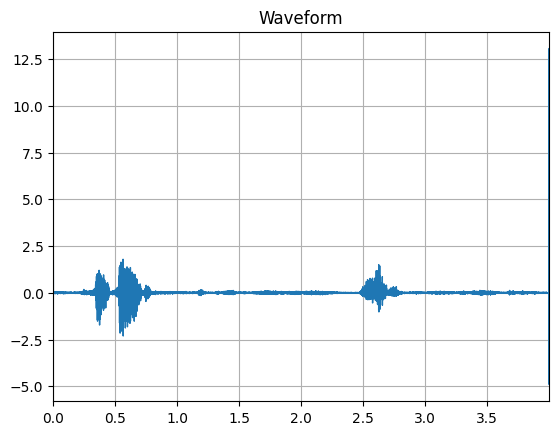

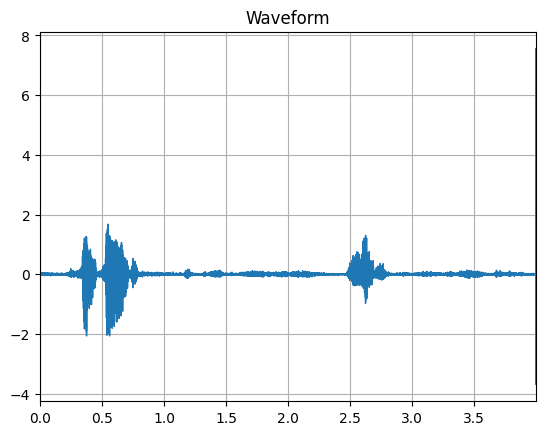

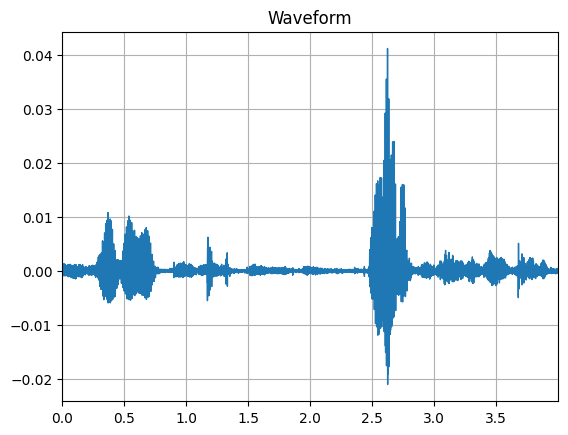

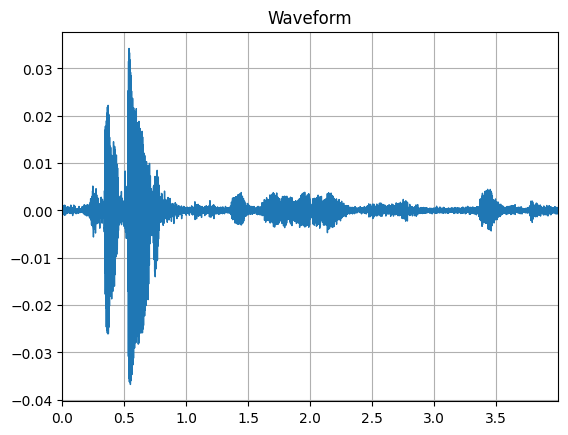

In [101]:
for mixed, clean in train_loader:
    print(mixed.shape, clean.shape, mixed[0][0][0])
    mixed = mixed.to(device)
    clean = clean.to(device)
    model.eval()
    outputs = model(mixed)
    print(outputs.shape)
    loss = criterion(outputs, clean)
    print(loss)
    break

outputs.shape, outputs[0][0].shape
plot_mono_waveform((outputs[0][0].cpu().detach()[:]), sr=8000)
plot_mono_waveform((outputs[0][1].cpu().detach()[:]), sr=8000)
plot_mono_waveform(clean[0][0].cpu().detach(), sr=8000)
plot_mono_waveform(clean[0][1].cpu().detach(), sr=8000)

In [104]:


prev_val_loss = float('inf')
consecutive_val_increases = 0
patience = 3

for epoch in range(2):
    epoch_loss = 0
    for s_idx, (mixed, clean) in tqdm(enumerate(train_loader), desc=f'Epoch {epoch + 1}', position=epoch, total=len(train_loader)):
        if s_idx < 79000:
            continue
        model.train()
        # print(mixed.shape, clean.shape)
        mixed = mixed.to(device)
        clean = clean.to(device)
        optimizer.zero_grad()
        outputs = model(mixed)
        # print(outputs.shape)
        loss = criterion(outputs, clean)
        # print(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


        batch_factor = 1#8
        frequency = 1000 * batch_factor
        if (s_idx) % frequency == 0:
            full_val_loss = 0
            for test_idx, (val_mixed, val_clean) in enumerate(test_loader):
                model.eval()
                with torch.no_grad():
                    print('Testing', test_idx ,'/', frequency * len(test_loader) / len(train_loader), end='\r')
                    val_mixed = val_mixed.to(device)
                    val_clean = val_clean.to(device)
                    val_outputs = model(val_mixed)
                    val_loss = criterion(val_outputs, val_clean)
                    full_val_loss += val_loss.item()
                    if test_idx >= frequency * len(test_loader) / len(train_loader):
                        break
                
            log_loss(epoch, s_idx, epoch_loss / (s_idx//batch_factor + 1), full_val_loss / (frequency * len(test_loader) / len(train_loader)))
            checkpoint_path = os.path.join(model_dir,f'simple_convtasnet_epoch{epoch+1}_{s_idx//batch_factor+1}.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved model checkpoint to {checkpoint_path}, Loss: {epoch_loss/(s_idx//batch_factor+1)}, Val_Loss: {full_val_loss/(frequency * len(test_loader) / len(train_loader))}")

            if full_val_loss > prev_val_loss:
                consecutive_val_increases +=1
                if consecutive_val_increases >= patience:
                    print('Early Stopping, val loss went up')
                    break
            else:
                consecutive_val_increases = 0
            prev_val_loss = full_val_loss



    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")
    checkpoint_path = checkpoint_path = os.path.join(model_dir,f'simple_convtasnet_epoch{epoch+1}_final.pth')
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Saved model checkpoint to {checkpoint_path}")
    full_val_loss = 0
    for test_idx, (val_mixed, val_clean) in enumerate(test_loader):
        model.eval()
        print('Testing', test_idx ,'/', len(test_loader), end='\r')
        val_mixed = val_mixed.to(device)
        val_clean = val_clean.to(device)
        val_outputs = model(val_mixed)
        val_loss = criterion(val_outputs, val_clean)
        full_val_loss += val_loss.item()
    print(f" Val_Loss: {full_val_loss/ len(test_loader)}")
    log_loss(epoch, s_idx, epoch_loss / (s_idx + 1), full_val_loss / len(test_loader), checkpoint='Final')

Epoch 1:   0%|          | 0/500000 [00:00<?, ?it/s]

Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_79001.pth, Loss: 7.48591665011373e-07, Val_Loss: -0.6108340178430081
Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_80001.pth, Loss: -0.016811336212293148, Val_Loss: -0.5408239783346653
Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_81001.pth, Loss: -0.03351927864704012, Val_Loss: -0.6585335820913315
Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_82001.pth, Loss: -0.052552408678875666, Val_Loss: -0.7367280966043472
Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_83001.pth, Loss: -0.06909813065691293, Val_Loss: -0.7510445356369019
Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_84001.pth, Loss: -0.08833037467396666, Val_Loss: -0.7966448581218719
Saved model checkpoint to ./models_bottleneck_kan_try_2\simple_convtasnet_epoch1_85001.pth, Loss: 

KeyboardInterrupt: 

In [105]:
criterion(outputs, clean)

tensor(-0.7619, device='cuda:0', grad_fn=<DivBackward0>)

Epoch 1:   0%|          | 0/500000 [00:00<?, ?it/s]

torch.Size([2, 1, 32000]) torch.Size([2, 2, 32000]) tensor(0.0004)
torch.Size([2, 2, 32000])
tensor(-7.5136, device='cuda:0', grad_fn=<DivBackward0>)


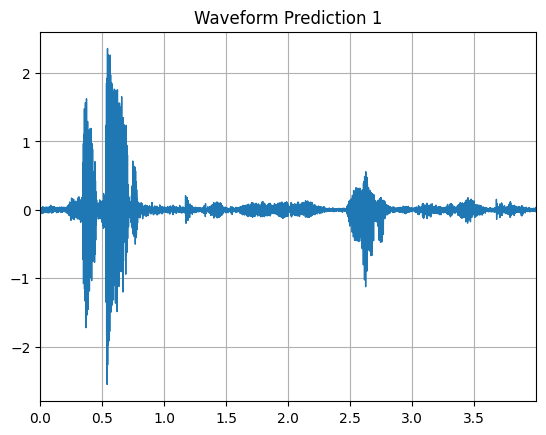

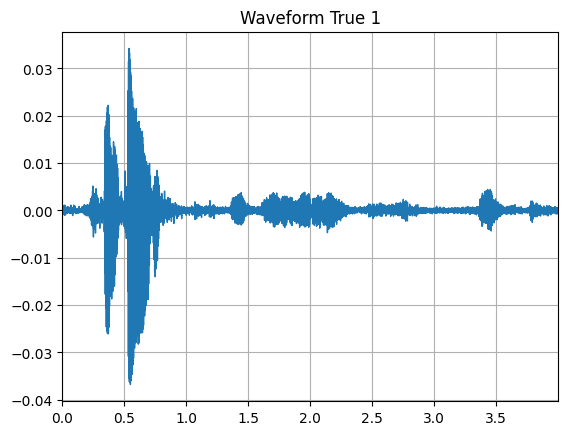

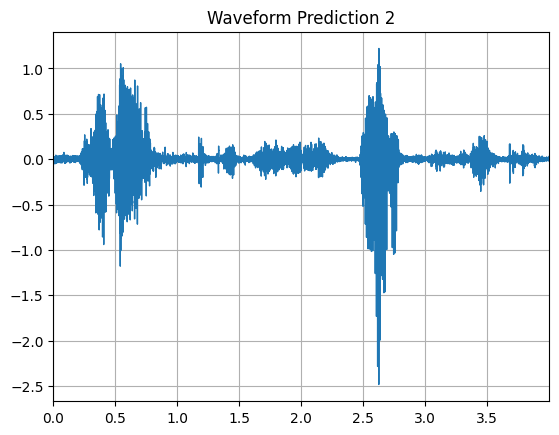

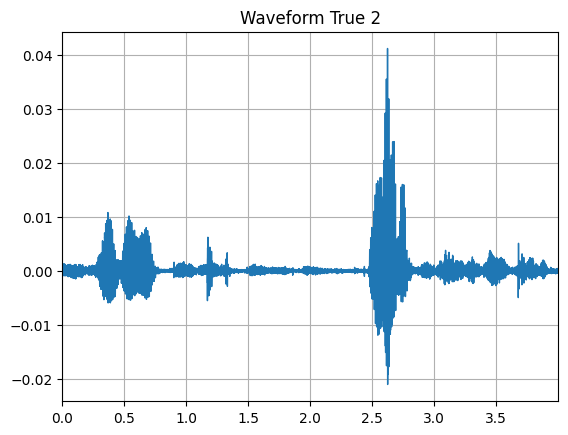

In [106]:
for mixed, clean in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        print(mixed.shape, clean.shape, mixed[0][0][0])
        mixed = mixed.to(device)
        clean = clean.to(device)
        model.eval()
        outputs = model(mixed)
        print(outputs.shape)
        loss = criterion(outputs, clean)
        print(loss)
        break

outputs.shape, outputs[0][0].shape
plot_mono_waveform((outputs[0][0].cpu().detach()[:]), sr=8000, title='Waveform Prediction 1')
plot_mono_waveform(clean[0][1].cpu().detach(), sr=8000, title='Waveform True 1')
plot_mono_waveform((outputs[0][1].cpu().detach()[:]), sr=8000, title='Waveform Prediction 2')
plot_mono_waveform(clean[0][0].cpu().detach(), sr=8000, title='Waveform True 2')